In this example, we will create a hexagonal lattice and show how the orientation can be changed via the cell rotation property. Let's first just set up some materials and universes that we will use to fill the lattice.

In [1]:
%matplotlib inline
import openmc

In [2]:
fuel = openmc.Material(name='fuel')
fuel.add_nuclide('U235', 1.0)
fuel.set_density('g/cm3', 10.0)

fuel2 = openmc.Material(name='fuel2')
fuel2.add_nuclide('U238', 1.0)
fuel2.set_density('g/cm3', 10.0)

water = openmc.Material(name='water')
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)

mats = openmc.Materials((fuel, fuel2, water))
mats.export_to_xml()

With our three materials, we will set up two universes that represent pin-cells: one with a small pin and one with a big pin. Since we will be using these universes in a lattice, it's always a good idea to have an "outer" universe as well that is applied outside the defined lattice.

In [3]:
r_pin = openmc.ZCylinder(r=0.25)
fuel_cell = openmc.Cell(fill=fuel, region=-r_pin)
water_cell = openmc.Cell(fill=water, region=+r_pin)
pin_universe = openmc.Universe(cells=(fuel_cell, water_cell))

r_big_pin = openmc.ZCylinder(r=0.5)
fuel2_cell = openmc.Cell(fill=fuel2, region=-r_big_pin)
water2_cell = openmc.Cell(fill=water, region=+r_big_pin)
big_pin_universe = openmc.Universe(cells=(fuel2_cell, water2_cell))

all_water_cell = openmc.Cell(fill=water)
outer_universe = openmc.Universe(cells=(all_water_cell,))

Now let's create a hexagonal lattice using the `HexLattice` class:

In [4]:
lat = openmc.HexLattice()

We need to set the `center` of the lattice, the `pitch`, an `outer` universe (which is applied to all lattice elements outside of those that are defined), and a list of `universes`. Let's start with the easy ones first. Note that for a 2D lattice, we only need to specify a single number for the pitch.

In [5]:
lat.center = (0., 0.)
lat.pitch = (1.25,)
lat.outer = outer_universe

Now we need to set the `universes` property on our lattice. It needs to be set to a list of lists of Universes, where each list of Universes corresponds to a ring of the lattice. The rings are ordered from outermost to innermost, and within each ring the indexing starts at the "top". To help visualize the proper indices, we can use the `show_indices()` helper method.

In [6]:
print(lat.show_indices(num_rings=3))

            (0, 0)
      (0,11)      (0, 1)
(0,10)      (1, 0)      (0, 2)
      (1, 5)      (1, 1)
(0, 9)      (2, 0)      (0, 3)
      (1, 4)      (1, 2)
(0, 8)      (1, 3)      (0, 4)
      (0, 7)      (0, 5)
            (0, 6)


Let's set up a lattice where the first element in each ring is the big pin universe and all other elements are regular pin universes. From the diagram above, we see that the outer ring has 12 elements, the middle ring has 6, and the innermost degenerate ring has a single element.

In [7]:
outer_ring = [big_pin_universe] + [pin_universe]*11
middle_ring = [big_pin_universe] + [pin_universe]*5
inner_ring = [big_pin_universe]
lat.universes = [outer_ring, middle_ring, inner_ring]
print(lat)

HexLattice
	ID             =	4
	Name           =	
	# Rings        =	3
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.25,)
	Outer          =	3
	Universes      
  2
 1 1
1 2 1
 1 1
1 2 1
 1 1
1 1 1
 1 1
  1


Now let's put our lattice inside a circular cell that will serve as the top-level cell for our geometry.

In [8]:
outer_surface = openmc.ZCylinder(r=4.0, boundary_type='vacuum')
main_cell = openmc.Cell(fill=lat, region=-outer_surface)
geom = openmc.Geometry([main_cell])
geom.export_to_xml()

Now let's create a plot to see what our geometry looks like.

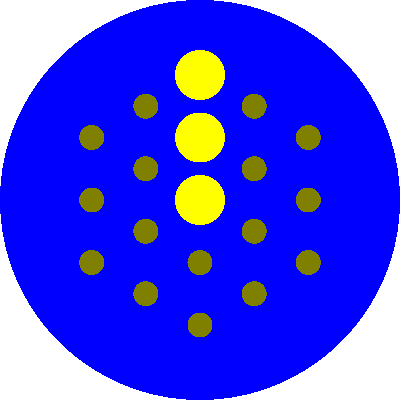

In [9]:
p = openmc.Plot.from_geometry(geom)
p.color_by = 'material'
p.colors = colors = {
    water: 'blue',
    fuel: 'olive',
    fuel2: 'yellow'
}
p.to_ipython_image()

At this point, if we wanted to simulate the model, we would need to create an instance of `openmc.Settings`, export it to XML, and run.

## Rotating the lattice

Now let's say we want our hexagonal lattice orientated such that flat sides of each lattice element are parallel to the y-axis instead of the x-axis. This can be achieved by rotating the cell that contains the lattice by 30 degrees.

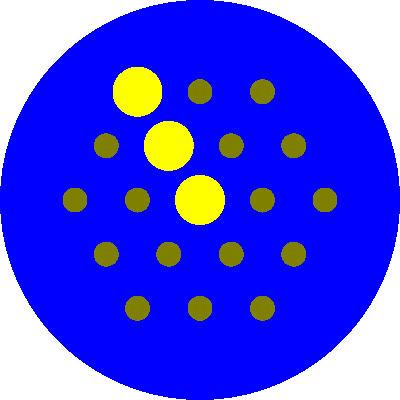

In [10]:
# Rotate the main cell and re-export the geometry
main_cell.rotation = (0., 0., 30.)
geom.export_to_xml()

# Run OpenMC in plotting mode
p.to_ipython_image()